### Text mining analysis and network analysis of the Oellrich, Walls et al., (2015) dataset
The purpose of this notebook is to evaluate the phenotype similarity network based off of hand-curated EQ statement annotations with GO, PO, PATO, and ChEBI terms with regards to how well this network clusters phenotypes related to genes which have known protein-protein interactions, have biochemical pathways in common, or are involved in common phenotype groupings. These properties of this network are compared against these properties in networks constructed from the same data but using natural language processing and machine learning approaches to evaluating text similarity, as well as combinations of these approaches using higher level models. Output from this notebook is saved with naming conventions according to when the notebook was run, and all outputs are saved as images or tables in CSV format.

The purpose of this notebook is to answer the question of how networks genereated using phenotypic-text similarity based approaches through either embedding, vocabulary presence, or ontology annotation compare to or relate to networks that specify known protein-protein interactions. The hypothesis that these networks are potentially related is based on the idea that if two proteins interact, they are likely to be acting in a common pathway with a common biological function. If the phenotypic outcome of this pathway is observable and documented, then similarites between text describing the mutant phenotype for these genes may coincide with direct protein-protein interactions. The different sections in this notebook correspond to different ways of determining if the graphs based on similarity between text descriptions, encodings of text descriptions, or annotations derived from text descriptions at all correspond to known protein-protein interactions in this dataset. The knowledge source about the protein-protein interactions for genes in this dataset is the STRING database. The available entries in the whole dataset are subset to include only the genes that correspond to proteins that are atleast mentioned in the STRING database. This ways if a protein-protein interaction is not specified between two of the remaining genes, it is not because no interactions at all are documented either of those genes. The following cells focus on setting up a dataframe which specifies edge lists specific to each similarity method, and also a protein-protein interaction score for the genes which correspond to those two given nodes in the graphs.

In [49]:
import datetime
import nltk
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import time
import math
import sys
import gensim
import os
import warnings
import torch
import itertools
import multiprocessing as mp
from collections import Counter, defaultdict
from inspect import signature
from scipy.stats import ks_2samp
from sklearn.metrics import precision_recall_curve, f1_score, auc
from sklearn.model_selection import train_test_split, KFold
from scipy import spatial, stats
from nltk.corpus import brown
from nltk.tokenize import word_tokenize
from sklearn.neighbors import KNeighborsClassifier
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

sys.path.append("../../oats")
from oats.utils.utils import save_to_pickle, load_from_pickle, merge_list_dicts, flatten, to_hms
from oats.datasets.dataset import Dataset
from oats.datasets.groupings import Groupings
from oats.annotation.ontology import Ontology
from oats.datasets.string import String
from oats.datasets.edges import Edges
from oats.annotation.annotation import annotate_using_noble_coder
from oats.graphs import pairwise as pw
from oats.graphs.indexed import IndexedGraph
from oats.graphs.models import train_logistic_regression_model, apply_logistic_regression_model
from oats.graphs.models import train_random_forest_model, apply_random_forest_model
from oats.nlp.vocabulary import get_overrepresented_tokens, build_vocabulary_from_tokens
from oats.utils.utils import function_wrapper_with_duration

mpl.rcParams["figure.dpi"] = 400
warnings.simplefilter('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
nltk.download('punkt')
nltk.download('brown')

[nltk_data] Downloading package punkt to /Users/irbraun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package brown to /Users/irbraun/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

### Definining the output and input file paths

In [50]:
# The summarizing output dictionary has the shape TABLE[method][(tag,metric)] --> value.
TOPIC = "KEGG Pathways"
DATA = "Training"
TABLE = defaultdict(dict)
OUTPUT_DIR = os.path.join("../outputs",datetime.datetime.now().strftime('%m_%d_%Y_h%Hm%Ms%S'))
os.mkdir(OUTPUT_DIR)

In [51]:
dataset_filename = "../data/pickles/training_dataset.pickle"                     # The full dataset pickle.
groupings_filename = "../data/pickles/pmn_pathways.pickle"                       # The groupings pickle.
background_corpus_filename = "../data/corpus_related_files/background.txt"       # Text file with background content.
phenotypes_corpus_filename = "../data/corpus_related_files/phenotypes_small.txt" # Text file with specific content.
doc2vec_pubmed_filename = "../gensim/pubmed_dbow/doc2vec_2.bin"                  # File holding saved Doc2Vec model.
doc2vec_wikipedia_filename = "../gensim/enwiki_dbow/doc2vec.bin"                 # File holding saved Doc2Vec model.
word2vec_model_filename = "../gensim/wiki_sg/word2vec.bin"                       # File holding saved Word2Vec model.
ontology_filename = "../ontologies/mo.obo"                                       # Ontology file in OBO format.
noblecoder_jarfile_path = "../lib/NobleCoder-1.0.jar"                            # Jar for NOBLE Coder tool.

### Reading in the dataset of genes, phenotypes, and annotations

In [52]:
dataset = load_from_pickle(dataset_filename)
dataset.describe()
dataset.filter_by_species("ath","zma")
dataset.describe()
dataset.to_pandas().head(10)

Number of rows in the dataframe: 17403
Number of unique IDs:            17403
Number of unique descriptions:   14287
Number of unique gene name sets: 17403
Number of species represented:   5
Number of rows in the dataframe: 4987
Number of unique IDs:            4987
Number of unique descriptions:   2403
Number of unique gene name sets: 4987
Number of species represented:   2


,id,species,gene_names,description,term_ids,pmid
0,0,ath,At5g41040|RWP1|AT5G41040|ASFT|HHT|REDUCED LEVE...,Abnormal aromatic suberin biosynthesis. Abnorm...,GO:0009058|CHEBI:60973|PATO:0001236|PATO:00004...,0 1 2 3 4 ...
1,1,ath,EMB1575,embryo defective; terminal embryo phenotype: c...,GO:0005575|GO:0003674|GO:0008150,0 Communication:501714663 1 ...
2,2,ath,EMB1576,embryo defective; terminal embryo phenotype: g...,GO:0003674|GO:0008150|GO:0005575,0 Communication:501714663 1 ...
3,3,ath,EMB1578,embryo defective; terminal embryo phenotype: c...,GO:0008150|GO:0005575|GO:0003674,0 Communication:501714663 1 ...
4,4,ath,EMB1580,embryo defective; terminal embryo phenotype: v...,GO:0008150|GO:0003674|GO:0005575,0 Communication:501714663 1 ...
5,5,ath,EMB1581,embryo defective; terminal embryo phenotype: g...,GO:0003674|GO:0005575|GO:0008150,0 Communication:501714663 1 ...
6,6,ath,EMB1582,embryo defective; terminal embryo phenotype: c...,GO:0003674|GO:0008150|GO:0005575,0 Communication:501714663 1 ...
7,7,ath,EMB1583,embryo defective; terminal embryo phenotype: p...,GO:0008150|GO:0003674|GO:0005575,0 Communication:501714663 1 ...
8,8,ath,EMB1584,embryo defective; terminal embryo phenotype: g...,GO:0008150|GO:0005575|GO:0003674,0 Communication:501714663 1 ...
9,9,ath,EMB1585,embryo defective; terminal embryo phenotype: p...,GO:0005575|GO:0008150|GO:0003674,0 Communication:501714663 1 ...


### Reading in pathway or grouping data

In [75]:
groups = load_from_pickle(groupings_filename)
id_to_group_ids = groups.get_id_to_group_ids_dict(dataset.get_gene_dictionary())
group_id_to_ids = groups.get_group_id_to_ids_dict(dataset.get_gene_dictionary())
group_mapped_ids = [k for (k,v) in id_to_group_ids.items() if len(v)>0]
groups.describe()
groups.to_csv(os.path.join(OUTPUT_DIR,"groupings.csv"))
groups.to_pandas().head(10)

Number of groups present for each species
  ath: 627
  zma: 565
  mtr: 520
  osa: 569
  gmx: 618
  sly: 524
Number of genes names mapped to any group for each species
  ath: 9959
  zma: 14319
  mtr: 14100
  osa: 12156
  gmx: 20677
  sly: 13232
  species pathway_id                                pathway_name                                         gene_names     ec_number
0     ath   PWY-5272  abscisic acid degradation by glucosylation  at1g52400-monomer|abscisic acid glucose ester ...  EC-3.2.1.175
1     ath   PWY-5272  abscisic acid degradation by glucosylation  at4g15550-monomer|abscisate &beta;-glucosyltra...  EC-2.4.1.263
2     ath   PWY-5272  abscisic acid degradation by glucosylation  at4g15260-monomer|abscisate &beta;-glucosyltra...  EC-2.4.1.263
3     ath   PWY-5272  abscisic acid degradation by glucosylation  at3g21790-monomer|abscisate &beta;-glucosyltra...  EC-2.4.1.263
4     ath   PWY-5272  abscisic acid degradation by glucosylation  at3g21760-monomer|abscisate &beta;-gluco

### Relating the dataset of genes to the pathway or grouping data
This section generates tables that indicate how the genes present in the dataset were mapped to the defined pathways or groups. This includes a summary table that indicates how many genes by species were succcessfully mapped to atleast one pathway or group, as well as a more detailed table describing how many genes from each species were mapped to each particular pathway or group.

In [54]:
# Generate a table describing how many of the genes input from each species map to atleast one group.
summary = defaultdict(dict)
species_dict = dataset.get_species_dictionary()
for species in dataset.get_species():
    summary[species]["input"] = len([x for x in dataset.get_ids() if species_dict[x]==species])
    summary[species]["mapped"] = len([x for x in group_mapped_ids if species_dict[x]==species])
table = pd.DataFrame(summary).transpose()
table.loc["total"]= table.sum()
table["fraction"] = table.apply(lambda row: "{:0.4f}".format(row["mapped"]/row["input"]), axis=1)
table = table.reset_index(inplace=False)
table = table.rename({"index":"species"}, axis="columns")
table.to_csv(os.path.join(OUTPUT_DIR,"mappings_summary.csv"), index=False)

# Generate a table describing how many genes from each species map to which particular group.
summary = defaultdict(dict)
for group_id,ids in group_id_to_ids.items():
    summary[group_id].update({species:len([x for x in ids if species_dict[x]==species]) for species in dataset.get_species()})
    summary[group_id]["total"] = len([x for x in ids])
table = pd.DataFrame(summary).transpose()
table = table.sort_values(by="total", ascending=False)
table = table.reset_index(inplace=False)
table = table.rename({"index":"pathway_id"}, axis="columns")
table["pathway_name"] = table["pathway_id"].map(groups.get_long_name)
table.loc["total"] = table.sum()
table.loc["total","pathway_id"] = "total"
table.loc["total","pathway_name"] = "total"
table = table[table.columns.tolist()[-1:] + table.columns.tolist()[:-1]]
table.to_csv(os.path.join(OUTPUT_DIR,"mappings_by_group.csv"), index=False)

### Reading in the protein-protein interaction data

In [55]:
# Reduce size of the dataset by removing genes not mentioned in the STRING.
naming_file = "../data/group_related_files/string/all_organisms.name_2_string.tsv"
interaction_files = [
    "../data/group_related_files/string/3702.protein.links.detailed.v11.0.txt", # Arabidopsis thaliana
    "../data/group_related_files/string/4577.protein.links.detailed.v11.0.txt", # maize
    "../data/group_related_files/string/4530.protein.links.detailed.v11.0.txt", # tomato 
    "../data/group_related_files/string/4081.protein.links.detailed.v11.0.txt", # medicago
    "../data/group_related_files/string/3880.protein.links.detailed.v11.0.txt", # rice 
    "../data/group_related_files/string/3847.protein.links.detailed.v11.0.txt", # soybean
]
#genes = dataset.get_gene_dictionary()
#string_data = String(genes, naming_file, *interaction_files)

# Filter the dataset based on whether or not the genes were successfully mapped to an interaction.
#dataset.filter_with_ids(string_data.ids)
#dataset.describe()

# Merging information from the protein-protein interaction database with this dataset.
#df = df.merge(right=string_data.df, how="left", on=["from","to"])
#df.fillna(value=0,inplace=True)
#df["interaction"] = (df["combined_score"] != 0.00)*1
#df.tail(12)

### Filtering the dataset
This is done to only include genes (and the corresponding phenotype descriptions and annotations) which are useful for the current analysis. In this case we want to only retain genes that are mapped to atleast one pathway in whatever the source of pathway membership we are using is (KEGG, Plant Metabolic Network, etc). This is because for these genes, it will be impossible to correctly predict their pathway membership, and we have no evidence that they belong or do not belong in certain pathways so they can not be identified as being true or false negatives in any case.

In [56]:
# Stuff that is specific to using STRING.
# Reduce size of the dataset by removing genes not mentioned in the STRING.
#naming_file = "../data/group_related_files/string/all_organisms.name_2_string.tsv"
#interactions_file_1 = "../data/group_related_files/string/3702.protein.links.detailed.v11.0.txt"
#interactions_file_2 = "../data/group_related_files/string/4577.protein.links.detailed.v11.0.txt"
#genes = dataset.get_gene_dictionary()
#string_data = String(genes, naming_file, interactions_file_1, interactions_file_2)
#group_mapped_ids = string_data.ids

In [57]:
# Filter based on succcessful mappings to groups or pathways.
dataset.filter_with_ids(group_mapped_ids)
dataset.describe()

Number of rows in the dataframe: 424
Number of unique IDs:            424
Number of unique descriptions:   352
Number of unique gene name sets: 424
Number of species represented:   2


In [58]:
# Get the mappings in each direction again now that the dataset has been subset.
id_to_group_ids = groups.get_id_to_group_ids_dict(dataset.get_gene_dictionary())
group_id_to_ids = groups.get_group_id_to_ids_dict(dataset.get_gene_dictionary())

### Loading NLP models and vocabularies

In [59]:
# Files and models related to the machine learning text embedding methods.
doc2vec_wiki_model = gensim.models.Doc2Vec.load(doc2vec_wikipedia_filename)
doc2vec_pubmed_model = gensim.models.Doc2Vec.load(doc2vec_pubmed_filename)
word2vec_model = gensim.models.Word2Vec.load(word2vec_model_filename)
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Constructing a vocabulary by looking at what words are overrepresented in domain specific text.
background_corpus = open(background_corpus_filename,"r").read()
phenotypes_corpus = open(phenotypes_corpus_filename,"r").read()
tokens = get_overrepresented_tokens(phenotypes_corpus, background_corpus, max_features=5000)
vocabulary_from_text = build_vocabulary_from_tokens(tokens)

# Constructing a vocabulary by assuming all words present in a given ontology are important.
ontology = Ontology(ontology_filename)
vocabulary_from_ontology = build_vocabulary_from_tokens(ontology.get_tokens())

# Loading other necessary objects or models and annotating text with ontology terms.
descriptions = dataset.get_description_dictionary()
annotations_from_dataset = dataset.get_annotations_dictionary()
annotations_noblecoder_precise = annotate_using_noble_coder(descriptions, noblecoder_jarfile_path, "mo", precise=1)
annotations_noblecoder_partial = annotate_using_noble_coder(descriptions, noblecoder_jarfile_path, "mo", precise=0)

# Generating random descriptions that are drawn from same token population and retain original lengths.
#tokens = [w for w in itertools.chain.from_iterable(word_tokenize(desc) for desc in descriptions.values())]
#scrambled_descriptions = {k:" ".join(np.random.choice(tokens,len(word_tokenize(v)))) for k,v in descriptions.items()}

### Preprocessing text descriptions
Normalizing case, lemmatization, stemming, removing stopwords, removing punctuation, handling numerics, creating parse trees, part-of-speech tagging, and anything else necessary for a particular dataset of descripitons.

### Generating vector representations and pairwise distances matrices
This section uses the text descriptions, preprocessed text descriptions, or ontology term annotations created or read in the previous sections to generate a vector representation for each gene and build a pairwise distance matrix for the whole dataset. Each method specified is a unique combination of a method of vectorization (bag-of-words, n-grams, document embedding model, etc) and distance metric (Euclidean, Jaccard, etc) applied to those vectors in constructing the pairwise matrix. The method of vectorization here is equivalent to feature selection, so the task is to figure out which type of vectors will encode features that are useful (n-grams, full words, only words from a certain vocabulary, etc).

In [60]:
# Define a list of tuples, each tuple will be used to build to find a matrix of pairwise distances.
# The naming scheme for methods should include both a name substring and then a hyperparameter substring
# separated by a colon. Anything after the colon will be removed from the name and put in a separate 
# column in the output table. This is so that the name column can be directly used for making figures, so
# if two hyperparameter choices are both going to be used in a figure, keep them in the name substring not
# the hyperparameter section. The required items in each tuple are:
# Index 0: name of the method
# Index 1: function to call for running this method
# Index 2: arguments to pass to that function as dictionary of keyword args
# Index 3: distance metric to apply to vectors generated with that method
name_function_args_tuples = [
    
    # Methods that use neural networks to generate embeddings.
    ("Doc2Vec Wikipedia:Size=300", pw.pairwise_doc2vec_onegroup, {"model":doc2vec_wiki_model, "object_dict":descriptions, "metric":"cosine"}, spatial.distance.cosine),
    ("Doc2Vec PubMed:Size=100", pw.pairwise_doc2vec_onegroup, {"model":doc2vec_pubmed_model, "object_dict":descriptions, "metric":"cosine"}, spatial.distance.cosine),
    ("BERT Base:Layers=2,Summed", pw.pairwise_bert_onegroup, {"model":bert_model, "tokenizer":bert_tokenizer, "object_dict":descriptions, "metric":"cosine", "method":"sum", "layers":2}, spatial.distance.cosine),
    ("BERT Base:Layers=3,Concatenated", pw.pairwise_bert_onegroup, {"model":bert_model, "tokenizer":bert_tokenizer, "object_dict":descriptions, "metric":"cosine", "method":"concat", "layers":3}, spatial.distance.cosine),
    ("BERT Base:Layers=4,Concatenated", pw.pairwise_bert_onegroup, {"model":bert_model, "tokenizer":bert_tokenizer, "object_dict":descriptions, "metric":"cosine", "method":"concat", "layers":4}, spatial.distance.cosine),
    ("Word2Vec Wikipedia:Size=300,Mean", pw.pairwise_word2vec_onegroup, {"model":word2vec_model, "object_dict":descriptions, "metric":"cosine", "method":"mean"}, spatial.distance.cosine),
    ("word2vec Wikipedia:Size=300,Mean", pw.pairwise_word2vec_onegroup, {"model":word2vec_model, "object_dict":descriptions, "metric":"cosine", "method":"max"}, spatial.distance.cosine),
    
    # Methods that use variations on the ngram approach.
    ("N-Grams:Words,1-grams,2-grams", pw.pairwise_ngrams_onegroup, {"object_dict":descriptions, "metric":"cosine", "binary":False, "analyzer":"word", "ngram_range":(1,2),"max_features":5000, "tfidf":False}, spatial.distance.cosine),
    ("N-Grams:Words,1-grams,2-grams,Binary", pw.pairwise_ngrams_onegroup, {"object_dict":descriptions, "metric":"cosine", "binary":True, "analyzer":"word", "ngram_range":(1,2), "max_features":5000, "tfidf":False}, spatial.distance.cosine),
    ("N-Grams:Words,1-grams", pw.pairwise_ngrams_onegroup, {"object_dict":descriptions, "metric":"cosine", "binary":False, "analyzer":"word", "ngram_range":(1,1), "max_features":5000, "tfidf":False}, spatial.distance.cosine),
    ("N-Grams:Words,1-grams,Binary", pw.pairwise_ngrams_onegroup, {"object_dict":descriptions, "metric":"jaccard", "binary":True, "analyzer":"word", "ngram_range":(1,1), "max_features":10000000, "tfidf":False}, spatial.distance.jaccard),
    ("N-Grams:Words,1-grams,2-grams,TFIDF", pw.pairwise_ngrams_onegroup, {"object_dict":descriptions, "metric":"cosine", "binary":False, "analyzer":"word", "ngram_range":(1,2),"max_features":5000, "tfidf":True}, spatial.distance.cosine),
    ("N-Grams:Words,1-grams,2-grams,Binary,TFIDF", pw.pairwise_ngrams_onegroup, {"object_dict":descriptions, "metric":"cosine", "binary":True, "analyzer":"word", "ngram_range":(1,2), "max_features":5000, "tfidf":True}, spatial.distance.cosine),
    ("N-Grams:Words,1-grams,TFIDF", pw.pairwise_ngrams_onegroup, {"object_dict":descriptions, "metric":"cosine", "binary":False, "analyzer":"word", "ngram_range":(1,1), "max_features":5000, "tfidf":True}, spatial.distance.cosine),
    ("N-Grams:Words,1-grams,Binary,TFIDF", pw.pairwise_ngrams_onegroup, {"object_dict":descriptions, "metric":"jaccard", "binary":True, "analyzer":"word", "ngram_range":(1,1), "max_features":5000, "tfidf":True}, spatial.distance.jaccard),
    
    # Methods that use terms inferred from automated annotation of the text.
    ("NOBLE Coder:Precise", pw.pairwise_annotations_onegroup, {"annotations_dict":annotations_noblecoder_precise, "ontology":ontology, "binary":True, "metric":"jaccard", "tfidf":False}, spatial.distance.jaccard),
    ("NOBLE Coder:Partial", pw.pairwise_annotations_onegroup, {"annotations_dict":annotations_noblecoder_partial, "ontology":ontology, "binary":True, "metric":"jaccard", "tfidf":False}, spatial.distance.jaccard),
    ("NOBLE Coder:Precise,TFIDF", pw.pairwise_annotations_onegroup, {"annotations_dict":annotations_noblecoder_precise, "ontology":ontology, "binary":True, "metric":"jaccard", "tfidf":True}, spatial.distance.jaccard),
    ("NOBLE Coder:Partial,TFIDF", pw.pairwise_annotations_onegroup, {"annotations_dict":annotations_noblecoder_partial, "ontology":ontology, "binary":True, "metric":"jaccard", "tfidf":True}, spatial.distance.jaccard),
]

In [61]:
# Generate all of the similarity matrices in parallel.
#start_time_mp = time.perf_counter()
#pool = mp.Pool(mp.cpu_count())
#results = [pool.apply_async(function_wrapper_with_duration, args=(func, args)) for (name,func,args,metric) in name_function_args_tuples]
#results = [result.get() for result in results]
#graphs = {tup[0]:result[0] for tup,result in zip(name_function_args_tuples,results)}
#metric_dict = {tup[0]:tup[3] for tup in name_function_args_tuples}
#durations = {tup[0]:result[1] for tup,result in zip(name_function_args_tuples,results)}
#pool.close()
#pool.join()    
#total_time_mp = time.perf_counter()-start_time_mp

# Reporting how long each matrix took to build and how much time parallel processing saved.
#print("Durations of generating each pairwise similarity matrix (hh:mm:ss)")
#print("-----------------------------------------------------------------")
#savings = total_time_mp/sum(durations.values())
#for (name,duration) in durations.items():
#    print("{:15} {}".format(name, to_hms(duration)))
#print("-----------------------------------------------------------------")
#print("{:15} {}".format("total", to_hms(sum(durations.values()))))
#print("{:15} {} ({:.2%} of single thread time)".format("multiprocess", to_hms(total_time_mp), savings))

In [62]:
# Generate all the pairwise distance matrices.
graphs = {tup[0]:tup[1](**tup[2]) for tup in name_function_args_tuples}
metric_dict = {tup[0]:tup[3] for tup in name_function_args_tuples}

In [63]:
# Merging all of the edgelist dataframes together.
methods = list(graphs.keys())
edgelists = {k:v.edgelist for k,v in graphs.items()}
df = pw.merge_edgelists(edgelists, default_value=0.000)
df = pw.remove_self_loops(df)
df.tail(10)

,from,to,Wikipedia,PubMed,BERT Base:4 Layers,BERT Base:3 Layers,BERT Base:2 Layers
90086,4917,4941,0.457284,0.439289,0.197197,0.181402,0.180953
90087,4917,4947,0.186682,0.417190,0.085302,0.082394,0.118496
90088,4917,4960,0.354117,0.277662,0.081720,0.080888,0.079556
90089,4917,4964,0.311962,0.226003,0.104669,0.095135,0.088088
90091,4941,4947,0.461115,0.535493,0.228977,0.221430,0.227311
90092,4941,4960,0.565348,0.403506,0.131061,0.124290,0.116699
90093,4941,4964,0.504047,0.486196,0.193484,0.200839,0.162447
90095,4947,4960,0.404233,0.469097,0.106954,0.112862,0.135041
90096,4947,4964,0.290695,0.368904,0.063166,0.068714,0.079082
90098,4960,4964,0.400508,0.307846,0.089105,0.099475,0.084053


### Merging in the previously curated similarity values from the publication
This section reads in a file that contains the previously calculated distance values from the Oellrich, Walls et al. (2015) dataset, and merges it with the values which are obtained here for all of the applicable natural language processing or machine learning methods used, so that the graphs which are specified by these sets of distances values can be evaluated side by side in the subsequent sections.

In [ ]:
pppn_edgelist_path = "../data/supplemental_files_oellrich_walls/13007_2015_53_MOESM9_ESM.txt"
pppn_edgelist = Edges(dataset.get_name_to_id_dictionary(), pppn_edgelist_path)
df = df.merge(right=pppn_edgelist.df, how="left", on=["from","to"])
df.fillna(value=0.000,inplace=True)
df.rename(columns={"value":"Curated"}, inplace=True)
df["Curated"] = 1-df["Curated"]
methods.append("Curated")
df.tail(10)

### Adding information specific to each edge
The relevant information for each edge includes questions like whether or not the two genes that edge connects share a group or biochemical pathway in common, or if those genes are from the same species. This information can then later be used as the target values for predictive models, or for filtering the graphs represented by these edge lists.

In [66]:
# Generate a column indicating whether or not the two genes have atleast one pathway in common.
df["shared"] = df[["from","to"]].apply(lambda x: len(set(id_to_group_ids[x["from"]]).intersection(set(id_to_group_ids[x["to"]])))>0, axis=1)*1
print(Counter(df["shared"].values))

# Generate a column indicating whether or not the two genes are from the same species.
species_dict = dataset.get_species_dictionary()
df["same"] = df[["from","to"]].apply(lambda x: species_dict[x["from"]]==species_dict[x["to"]],axis=1)*1
print(Counter(df["same"].values))

Counter({0: 88440, 1: 1236})
Counter({1: 58421, 0: 31255})


### Combining multiple distance methods with machine learning models
The purpose of this section is to iteratively train models on subsections of the dataset using simple regression or machine learning approaches to predict a value from zero to one indicating indicating how likely is it that two genes share atleast one of the specified groups in common. The information input to these models is the distance scores provided by each method in some set of all the methods used in this notebook. The purpose is to see whether or not a function of these similarity scores specifically trained to the task of predicting common groupings is better able to used the distance metric information to report a score for this task.

In [67]:
"""
# Iteratively create models for combining output values from multiple semantic similarity methods.
method = "Logistic Regression"
splits = 12
kf = KFold(n_splits=splits, random_state=14271, shuffle=True)
df[method] = pd.Series()
for train,test in kf.split(df):
    lr_model = train_logistic_regression_model(df=df.iloc[train], predictor_columns=methods, target_column="shared")
    df[method].iloc[test] = apply_logistic_regression_model(df=df.iloc[test], predictor_columns=methods, model=lr_model)
df[method] = 1-df[method]
methods.append(method)
"""

In [ ]:
"""
# Iteratively create models for combining output values from multiple semantic similarity methods.
method = "Random Forest"
splits = 2
kf = KFold(n_splits=splits, random_state=14271, shuffle=True)
df[method] = pd.Series()
for train,test in kf.split(df):
    rf_model = train_random_forest_model(df=df.iloc[train], predictor_columns=methods, target_column="shared")
    df[method].iloc[test] = apply_random_forest_model(df=df.iloc[test],predictor_columns=methods, model=rf_model)
df[method] = 1-df[method]
methods.append(method)
"""

In [76]:
# Don't do it iteratively, just treat this entire dataset as training data and save the models.
# Logistic Regression
lr_name = "Logistic Regression"
model = train_logistic_regression_model(df=df, predictor_columns=methods, target_column="shared")
df[lr_name] = apply_logistic_regression_model(df=df, predictor_columns=methods, model=model)
df[lr_name] = 1-df[lr_name]
save_to_pickle(obj=model,path="../data/pickles/lr.model")
# Random Forest
rf_name = "Random Forest"
model = train_random_forest_model(df=df, predictor_columns=methods, target_column="shared")
df[rf_name] = apply_random_forest_model(df=df, predictor_columns=methods, model=model)
df[rf_name] = 1-df[rf_name]
save_to_pickle(obj=model,path="../data/pickles/rf.model")
# Add these methods to the method names to use for the below analysis.
methods.append(lr_name)
methods.append(rf_name)

### Do the edges joining genes that share atleast one pathway come from a different distribution?
The purpose of this section is to visualize kernel estimates for the distributions of distance or similarity scores generated by each of the methods tested for measuring semantic similarity or generating vector representations of the phenotype descriptions. Ideally, better methods should show better separation betwene the distributions for distance values between two genes involved in a common specified group or two genes that are not. Additionally, a statistical test is used to check whether these two distributions are significantly different from each other or not, although this is a less informative measure than the other tests used in subsequent sections, because it does not address how useful these differences in the distributions actually are for making predictions about group membership.

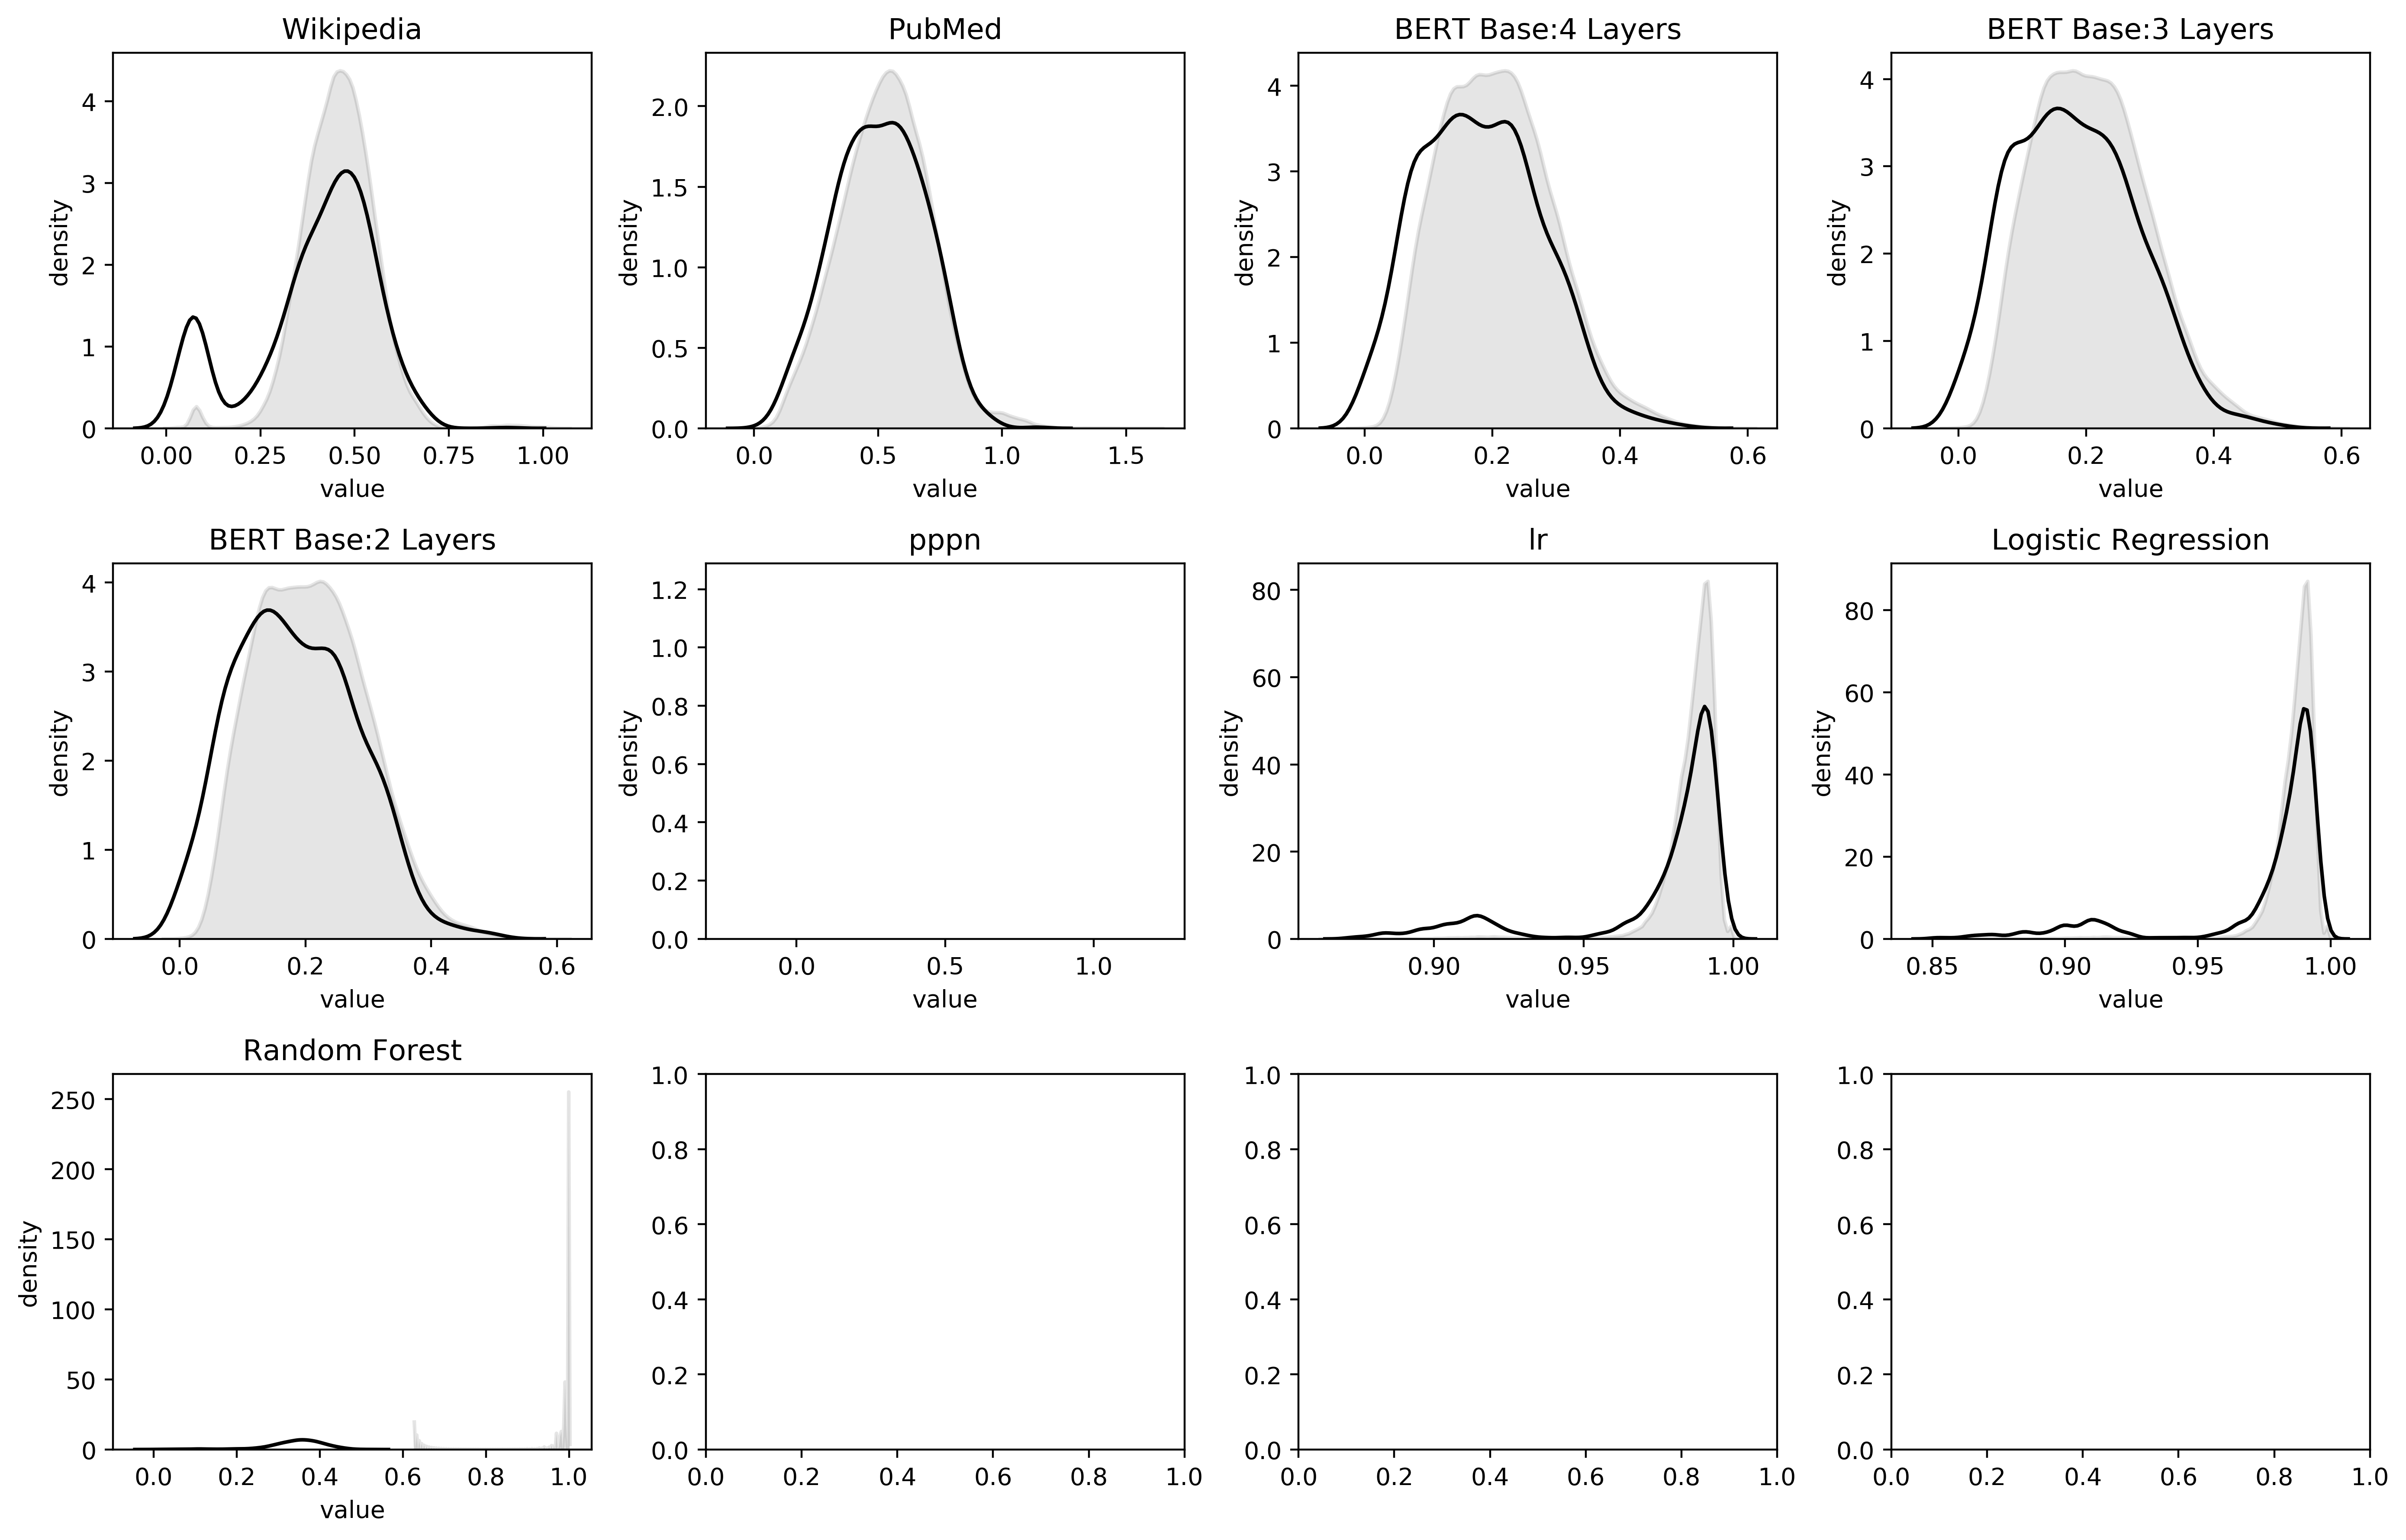

In [77]:
# Use Kolmogorov-Smirnov test to see if edges between genes that share a group come from a distinct distribution.
ppi_pos_dict = {name:(df[df["shared"] > 0.00][name].values) for name in methods}
ppi_neg_dict = {name:(df[df["shared"] == 0.00][name].values) for name in methods}
for name in methods:
    stat,p = ks_2samp(ppi_pos_dict[name],ppi_neg_dict[name])
    pos_mean = np.average(ppi_pos_dict[name])
    neg_mean = np.average(ppi_neg_dict[name])
    pos_n = len(ppi_pos_dict[name])
    neg_n = len(ppi_neg_dict[name])
    TABLE[name].update({"mean_1":pos_mean, "mean_0":neg_mean, "n_1":pos_n, "n_0":neg_n})
    TABLE[name].update({"ks":stat, "ks_pval":p})
    
    

# Show the kernel estimates for each distribution of weights for each method.
num_plots, plots_per_row, row_width, row_height = (len(methods), 4, 14, 3)
fig,axs = plt.subplots(math.ceil(num_plots/plots_per_row), plots_per_row, squeeze=False)
for name,ax in zip(methods,axs.flatten()):
    ax.set_title(name)
    ax.set_xlabel("value")
    ax.set_ylabel("density")
    sns.kdeplot(ppi_pos_dict[name], color="black", shade=False, alpha=1.0, ax=ax)
    sns.kdeplot(ppi_neg_dict[name], color="black", shade=True, alpha=0.1, ax=ax) 
fig.set_size_inches(row_width, row_height*math.ceil(num_plots/plots_per_row))
fig.tight_layout()
fig.savefig(os.path.join(OUTPUT_DIR,"kernel_density.png"),dpi=400)

### Looking at within-group or within-pathway distances in each graph
The purpose of this section is to determine which methods generated graphs which tightly group genes which share common pathways or group membership with one another. In order to compare across different methods where the distance value distributions are different, the mean distance values for each group for each method are convereted to percentile scores. Lower percentile scores indicate that the average distance value between any two genes that belong to that group is lower than most of the distance values in the entire distribution for that method.

In [ ]:
# Get all the average within-pathway phenotype distance values for each method for each particular pathway.
group_id_to_ids = groups.get_group_id_to_ids_dict(dataset.get_gene_dictionary())
group_ids = list(group_id_to_ids.keys())
graph = IndexedGraph(df)
within_weights_dict = defaultdict(lambda: defaultdict(list))
within_percentiles_dict = defaultdict(lambda: defaultdict(list))
all_weights_dict = {}
for method in methods:
    all_weights_dict[method] = df[method].values
    for group in group_ids:
        within_ids = group_id_to_ids[group]
        within_pairs = [(i,j) for i,j in itertools.permutations(within_ids,2)]
        mean_weight = np.mean((graph.get_values(within_pairs, kind=method)))
        within_weights_dict[method][group] = mean_weight
        within_percentiles_dict[method][group] = stats.percentileofscore(df[method].values, mean_weight, kind="rank")

# Generating a dataframe of percentiles of the mean in-group distance scores.
heatmap_data = pd.DataFrame(within_percentiles_dict)
heatmap_data = heatmap_data.dropna(axis=0, inplace=False)
heatmap_data = heatmap_data.round(4)

# Adding relevant information to this dataframe and saving.
heatmap_data["avg_rank"] = heatmap_data.rank().mean(axis=1)
heatmap_data.sort_values(by="avg_rank", inplace=True)
heatmap_data.reset_index(inplace=True)
heatmap_data["group_id"] = heatmap_data["index"]
heatmap_data["full_name"] = heatmap_data["group_id"].apply(lambda x: groups.get_long_name(x))
heatmap_data["n"] = heatmap_data["group_id"].apply(lambda x: len(group_id_to_ids[x]))
heatmap_data = heatmap_data[flatten(["group_id","full_name","n","avg_rank",methods])]
heatmap_data.to_csv(os.path.join(OUTPUT_DIR,"within_distances.csv"), index=False)
heatmap_data.head(20)

### Predicting whether two genes belong to a common biochemical pathway
The purpose of this section is to see if whether or not two genes share atleast one common pathway can be predicted from the distance scores assigned using analysis of text similarity. The evaluation of predictability is done by reporting a precision and recall curve for each method, as well as remembering the area under the curve, and ratio between the area under the curve and the baseline (expected area when guessing randomly) for each method.

In [ ]:
y_true_dict = {name:df["shared"] for name in methods}
y_prob_dict = {name:(1 - df[name].values) for name in methods}
num_plots, plots_per_row, row_width, row_height = (len(methods), 4, 14, 3)
fig,axs = plt.subplots(math.ceil(num_plots/plots_per_row), plots_per_row, squeeze=False)
for method,ax in zip(methods, axs.flatten()):
    
    # Obtaining the values and metrics.
    y_true, y_prob = y_true_dict[method], y_prob_dict[method]
    n_pos, n_neg = Counter(y_true)[1], Counter(y_true)[0]
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    baseline = Counter(y_true)[1]/len(y_true) 
    area = auc(recall, precision)
    auc_to_baseline_auc_ratio = area/baseline
    TABLE[method].update({(TAG,"auc"):area, (TAG,"baseline"):baseline, (TAG,"ratio"):auc_to_baseline_auc_ratio})

    # Producing the precision recall curve.
    step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
    ax.step(recall, precision, color='black', alpha=0.2, where='post')
    ax.fill_between(recall, precision, alpha=0.7, color='black', **step_kwargs)
    ax.axhline(baseline, linestyle="--", color="lightgray")
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title("PR {0} (Baseline={1:0.3f})".format(method, baseline))
    
fig.set_size_inches(row_width, row_height*math.ceil(num_plots/plots_per_row))
fig.tight_layout()
fig.savefig(os.path.join(OUTPUT_DIR,"prcurve_shared.png"),dpi=400)

### Are genes in the same biochemical pathway ranked higher with respect to individual nodes?
This is a way of statistically seeing if for some value k, the graph ranks more edges from some particular gene to any other gene that it has a true protein-protein interaction with higher or equal to rank k, than we would expect due to random chance. This way of looking at the problem helps to be less ambiguous than the previous methods, because it gets at the core of how this would actually be used. In other words, we don't really care how much true information we're missing as long as we're still able to pick up some new useful information by building these networks, so even though we could be missing a lot, what's going on at the very top of the results? These results should be comparable to very strictly thresholding the network and saying that the remaining edges are our guesses at interactions. This is comparable to just looking at the far left-hand side of the precision recall curves, but just quantifies it slightly differently.

In [ ]:
# When the edgelist is generated above, only the lower triangle of the pairwise matrix is retained for edges in the 
# graph. This means that in terms of the indices of each node, only the (i,j) node is listed in the edge list where
# i is less than j. This makes sense because the graph that's specified is assumed to already be undirected. However
# in order to be able to easily subset the edgelist by a single column to obtain rows that correspond to all edges
# connected to a particular node, this method will double the number of rows to include both (i,j) and (j,i) edges.
df = pw.make_undirected(df)

# What's the number of functional partners ranked k or higher in terms of phenotypic description similarity for 
# each gene? Also figure out the maximum possible number of functional partners that could be theoretically
# recovered in this dataset if recovered means being ranked as k or higher here.
k = 10      # The threshold of interest for gene ranks.
n = 100     # Number of Monte Carlo simulation iterations to complete.
df[list(methods)] = df.groupby("from")[list(methods)].rank()
ys = df[df["shared"]==1][list(methods)].apply(lambda s: len([x for x in s if x<=k]))
ymax = sum(df.groupby("from")["shared"].apply(lambda s: min(len([x for x in s if x==1]),k)))

# Monte Carlo simulation to see what the probability is of achieving each y-value by just randomly pulling k 
# edges for each gene rather than taking the top k ones that the similarity methods specifies when ranking.
ysims = [sum(df.groupby("from")["shared"].apply(lambda s: len([x for x in s.sample(k) if x>0.00]))) for i in range(n)]
for method in methods:
    pvalue = len([ysim for ysim in ysims if ysim>=ys[method]])/float(n)
    TABLE[method][(TAG,"y")] = ys[method]
    TABLE[method][(TAG,"y_max")] = ymax
    TABLE[method][(TAG,"y_ratio")] = ys[method]/ymax
    TABLE[method][(TAG,"y_pval")] = pvalue

### Predicting biochemical pathway or group membership based on mean vectors
This section looks at how well the biochemical pathways that a particular gene is a member of can be predicted based on the similarity between the vector representation of the phenotype descriptions for that gene and the average vector for all the vector representations of phenotypes asociated with genes that belong to that particular pathway. In calculating the average vector for a given biochemical pathway, the vector corresponding to the gene that is currently being classified is not accounted for, to avoid overestimating the performance by including information about the ground truth during classification. This leads to missing information in the case of biochemical pathways that have only one member. This can be accounted for by only limiting the overall dataset to only include genes that belong to pathways that have atleast two genes mapped to them, and only including those pathways, or by removing the missing values before calculating the performance metrics below.

In [ ]:
# Get the list of methods to look at, and a mapping between each method and the correct similarity metric to apply.
vector_dicts = {k:v.vector_dictionary for k,v in graphs.items()}
methods = list(vector_dicts.keys())
group_id_to_ids = groups.get_group_id_to_ids_dict(dataset.get_gene_dictionary())
valid_group_ids = [group for group,id_list in group_id_to_ids.items() if len(id_list)>1]
valid_ids = [i for i in dataset.get_ids() if len(set(valid_group_ids).intersection(set(id_to_group_ids[i])))>0]
pred_dict = defaultdict(lambda: defaultdict(dict))
true_dict = defaultdict(lambda: defaultdict(dict))
for method in methods:
    for group in valid_group_ids:
        ids = group_id_to_ids[group]
        for identifier in valid_ids:
            # What's the mean vector of this group, without this particular one that we're trying to classify.
            vectors = np.array([vector_dicts[method][some_id] for some_id in ids if not some_id==identifier])
            mean_vector = vectors.mean(axis=0)
            this_vector = vector_dicts[method][identifier]
            pred_dict[method][identifier][group] = 1-metric_dict[method](mean_vector, this_vector)
            true_dict[method][identifier][group] = (identifier in group_id_to_ids[group])*1                

In [ ]:
num_plots, plots_per_row, row_width, row_height = (len(methods), 4, 14, 3)
fig,axs = plt.subplots(math.ceil(num_plots/plots_per_row), plots_per_row, squeeze=False)
for method,ax in zip(methods, axs.flatten()):
    
    # Obtaining the values and metrics.
    y_true = pd.DataFrame(true_dict[method]).as_matrix().flatten()
    y_prob = pd.DataFrame(pred_dict[method]).as_matrix().flatten()
    n_pos, n_neg = Counter(y_true)[1], Counter(y_true)[0]
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    baseline = Counter(y_true)[1]/len(y_true) 
    area = auc(recall, precision)
    auc_to_baseline_auc_ratio = area/baseline
    TABLE[method].update({(TAG,"mean_auc"):area, (TAG,"mean_baseline"):baseline, (TAG,"mean_ratio"):auc_to_baseline_auc_ratio})

    # Producing the precision recall curve.
    step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
    ax.step(recall, precision, color='black', alpha=0.2, where='post')
    ax.fill_between(recall, precision, alpha=0.7, color='black', **step_kwargs)
    ax.axhline(baseline, linestyle="--", color="lightgray")
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title("PR {0} (Baseline={1:0.3f})".format(method, baseline))
    
fig.set_size_inches(row_width, row_height*math.ceil(num_plots/plots_per_row))
fig.tight_layout()
fig.show()
fig.savefig(os.path.join(OUTPUT_DIR,"prcurve_mean_classifier.png"),dpi=400)

### Predicting biochemical pathway membership based on mean similarity values
This section looks at how well the biochemical pathways that a particular gene is a member of can be predicted based on the average similarity between the vector representationt of the phenotype descriptions for that gene and each of the vector representations for other phenotypes associated with genes that belong to that particular pathway. In calculating the average similarity to other genes from a given biochemical pathway, the gene that is currently being classified is not accounted for, to avoid overestimating the performance by including information about the ground truth during classification. This leads to missing information in the case of biochemical pathways that have only one member. This can be accounted for by only limiting the overall dataset to only include genes that belong to pathways that have atleast two genes mapped to them, and only including those pathways, or by removing the missing values before calculating the performance metrics below.

### Predicting biochemical pathway or group membership with KNN classifier
This section looks at how well the group(s) or biochemical pathway(s) that a particular gene belongs to can be predicted based on a KNN classifier generated using every other gene. For this section, only the groups or pathways which contain more than one gene, and the genes mapped to those groups or pathways, are of interest. This is because for other genes, if we consider them then it will be true that that gene belongs to that group in the target vector, but the KNN classifier could never predict this because when that gene is held out, nothing could provide a vote for that group, because there are zero genes available to be memebers of the K nearest neighbors.

In [ ]:
"""
valid_group_ids = [group for group,id_list in group_id_to_ids.items() if len(id_list)>1]
valid_ids = [i for i in dataset.get_ids() if len(set(valid_group_ids).intersection(set(id_to_group_ids[i])))>0]

# Leave one out predictions.
pred_dict = defaultdict(lambda: defaultdict(dict))
true_dict = defaultdict(lambda: defaultdict(dict))

for method in methods:
    for i in valid_ids:
        ids = [identifier for identifier in valid_ids if identifier!=i]
        # Make the labels just the ID's for that gene instead of pathways or groups, transform votes later.
        X = [vector_dicts[method][identifier] for identifier in ids]
        y = [identifier for identifier in ids]
        neigh = KNeighborsClassifier(n_neighbors=5)
        neigh.fit(X,y)
        probs = neigh.predict_proba([vector_dicts[method][i]])
        # The classes are given in lexicographic order from the predict_proba method.
        # 1. Create a 2D binary array with a row for each group and a column for each gene.
        # 2. Multiply each row of that 2D binary array with the 1D array that has the probability for each gene.
        # 3. Find the sum of each row to get the score specific to each group for this particular gene.
        # 4. Append to the arrays for the true binary classifications and the predictions for each group. 
        ids.sort()
        binary_arr = np.array([[(group_id in id_to_group_ids[x])*1 for x in ids] for group_id in valid_group_ids]) 
        group_probs_by_gene = probs*binary_arr
        group_probs = np.sum(group_probs_by_gene, axis=1)
        for group_index,group_id in enumerate(valid_group_ids):
            pred_dict[method][i][group_id] = group_probs[group_index]
            true_dict[method][i][group_id] = (i in group_id_to_ids[group_id])*1
"""

In [ ]:
"""
num_plots, plots_per_row, row_width, row_height = (len(methods), 4, 14, 3)
fig,axs = plt.subplots(math.ceil(num_plots/plots_per_row), plots_per_row, squeeze=False)
for method,ax in zip(methods, axs.flatten()):
    
    # Obtaining the values and metrics.
    y_true = pd.DataFrame(true_dict[method]).as_matrix().flatten()
    y_prob = pd.DataFrame(pred_dict[method]).as_matrix().flatten()
    n_pos, n_neg = Counter(y_true)[1], Counter(y_true)[0]
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    baseline = Counter(y_true)[1]/len(y_true) 
    area = auc(recall, precision)
    auc_to_baseline_auc_ratio = area/baseline
    TABLE[method].update({(TAG,"knn_auc"):area, (TAG,"knn_baseline"):baseline, (TAG,"knn_ratio"):auc_to_baseline_auc_ratio})

    # Producing the precision recall curve.
    step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
    ax.step(recall, precision, color='black', alpha=0.2, where='post')
    ax.fill_between(recall, precision, alpha=0.7, color='black', **step_kwargs)
    ax.axhline(baseline, linestyle="--", color="lightgray")
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title("PR {0} (Baseline={1:0.3f})".format(method, baseline))
    
fig.set_size_inches(row_width, row_height*math.ceil(num_plots/plots_per_row))
fig.tight_layout()
fig.show()
fig.savefig(os.path.join(OUTPUT_DIR,"prcurve_knn_classifier.png"))
"""

### Summarizing the results for this notebook

In [74]:
results = pd.DataFrame(TABLE).transpose()
columns = flatten(["Hyperparams","Topic","Data",results.columns])
results["Hyperparams"] = ""
results["Topic"] = TOPIC
results["Data"] = DATA
results = results[columns]
results.reset_index(inplace=True)
results = results.rename({"index":"Method"}, axis="columns")
hyperparam_sep = ":"
results["Hyperparams"] = results["Method"].map(lambda x: x.split(hyperparam_sep)[1] if hyperparam_sep in x else "-")
results["Method"] = results["Method"].map(lambda x: x.split(hyperparam_sep)[0])
results.to_csv(os.path.join(OUTPUT_DIR,"full_table.csv"), index=True)
results

,Method,Hyperparams,Topic,Data,mean_1,mean_0,n_1,n_0,ks,ks_pval
0,Wikipedia,-,KEGG Pathways,Training,0.393579,0.457762,1236.0,88440.0,0.187337,1.389984e-37
1,PubMed,-,KEGG Pathways,Training,0.505234,0.530929,1236.0,88440.0,0.074715,2.458046e-06
2,BERT Base,4 Layers,KEGG Pathways,Training,0.181189,0.209134,1236.0,88440.0,0.133176,3.332069e-19
3,BERT Base,3 Layers,KEGG Pathways,Training,0.181800,0.210505,1236.0,88440.0,0.140673,2.233804e-21
4,BERT Base,2 Layers,KEGG Pathways,Training,0.184656,0.211359,1236.0,88440.0,0.128326,7.335350e-18
5,pppn,-,KEGG Pathways,Training,0.000000,0.000000,1236.0,88440.0,-0.000000,1.000000e+00
6,lr,-,KEGG Pathways,Training,0.974168,0.986367,1236.0,88440.0,0.193137,6.404826e-40


### Can machine learning approaches learn relationships between concepts that are in ontologies?
If the neural network document encoding models (Doc2Vec) are being successfully trained, then they should be able to recapture some of the domain-specific information that is written into relationships present in biological ontologies. Specifically, two concepts which have a parent-child relationship in PATO or PO can be considered to be highly similar in this context. We compare the distances between the labels for these pairs of terms as inferred by both the general Doc2Vec model trained on the English Wikipedia corpus, as well as our own models trained specifically on abstracts from PubMed that are specific to plant phenotypes. Here we generate figures to compare the results for a specific set of handpicked phrase or term pairs, as well as a second figure over all pairs parsed from the hierarchies in each ontology to check whether the result generalizes to the ontologies as a whole.

In [ ]:
"""
# Convert the distance values in the dataframe to be percentiles.
df_pct = df.copy()
df_pct[methods] = df[methods].rank(pct=True)

# Looking through the distances that are low for PubMed and high for Wikipedia to see if this is a valuable approach.
of_interest = df_pct[(df_pct["doc2vec_pubmed"]<0.1) & (df_pct["doc2vec_wiki"]>0.3)]
for row in of_interest.itertuples():
    print("{} and {}".format(round(row[4],4),round(row[3],4)))
    sentence1 = descriptions[row[1]]
    sentence2 = descriptions[row[2]]
    print("1: {}\n2: {}\n\n".format(sentence1, sentence2))
    
# Looking at the distance values of sentence variations of interest found in the previous step. 
sentences = {
    0:"Susceptible to bacterial infection",
    1:"Resistant to bacterial infection",
    2:"Resistant to powdery mildew",
    3:"susceptible to powdery mildew",
    4:"Some random control sentence"
}
wikipedia_results = pw.pairwise_doc2vec_onegroup(doc2vec_wiki_model,sentences,"cosine").edgelist
wikipedia_results["value"] = wikipedia_results["value"].map(lambda x: stats.percentileofscore(df["doc2vec_wiki"].values, x, kind="rank")/100)
wikipedia_results = pw.remove_self_loops(wikipedia_results)
pubmed_results = pw.pairwise_doc2vec_onegroup(doc2vec_pubmed_model,sentences,"cosine").edgelist
pubmed_results["value"] = pubmed_results["value"].map(lambda x: stats.percentileofscore(df["doc2vec_pubmed"].values, x, kind="rank")/100)
pubmed_results = pw.remove_self_loops(pubmed_results)
results = pw.merge_edgelists({"wikipedia":wikipedia_results,"pubmed":pubmed_results})
results
"""

In [ ]:
from scipy.spatial.distance import cosine
from scipy.spatial.distance import jaccard

# Loading a file of handpicked phrase pairs from ontology term labels. 
pairs = pd.read_csv("../data/corpus_related_files/phrase_pairs.csv")

# Adding the distance values found with each method to the dataframe.
# Another valid background distribution for each method could be the distance between all pairs of term labels.
pairs["Wikipedia"] = pw.elemwise_doc2vec_twogroup(doc2vec_wiki_model, pairs["Label 1"].values, pairs["Label 2"].values, cosine)
pairs["PubMed"] = pw.elemwise_doc2vec_twogroup(doc2vec_pubmed_model, pairs["Label 1"].values, pairs["Label 2"].values, cosine)
pairs["Jaccard"] = pw.elemwise_ngrams_twogroup(pairs["Label 1"].values, pairs["Label 2"].values, jaccard)
pairs["Wikipedia"] = pairs["Wikipedia"].map(lambda x: stats.percentileofscore(df["Wikipedia"].values, x, kind="rank")/100)
pairs["PubMed"] = pairs["PubMed"].map(lambda x: stats.percentileofscore(df["PubMed"].values, x, kind="rank")/100)
pairs["Pair"] = pairs["Label 1"].values+","+pairs["Label 2"].values
pairs.to_csv("../data/scratch/phrase_pair_handpicked_results.csv",index=False)
pairs

In [ ]:
import pronto

# Define the ontologies to be used for this section, using the pronto library to read them.
ontologies = {"PATO":pronto.Ontology("../ontologies/pato.obo"), "PO":pronto.Ontology("../ontologies/po.obo")}
tuples = []

# Iterate through the ontologies and all parent/child and sibling term label pairs.
for ont_name,ont in ontologies.items():
    delim = "[DELIM]"
    sibling_pairs = set()
    for term in ont:
        for parent in term.parents.id:
            tuples.append((ont_name,"parent_child",term.name,ont[parent].name))     
        sorted_id_pairs = [sorted(pair) for pair in list(itertools.combinations(term.children.id, 2))]
        sorted_pairs = ["{}{}{}".format(ont[pair[0]].name, delim, ont[pair[1]].name) for pair in sorted_id_pairs]
        sibling_pairs.update(sorted_pairs)
    for pair in list(sibling_pairs):
        pair = pair.split(delim)
        tuples.append((ont_name,"sibling",pair[0],pair[1]))  

In [ ]:
# Using that dataframe to see how the generalized distance percentile distributions compare between models.
pairs = pd.DataFrame(tuples, columns=["Ontology", "Relationship", "Label 1", "Label 2"])

# Adding the distance values found with each method to the dataframe.
# Another valid background distribution for each method could be the distance between all pairs of term labels.
pairs["Wikipedia"] = pw.elemwise_doc2vec_twogroup(doc2vec_wiki_model, pairs["Label 1"].values, pairs["Label 2"].values, cosine)
pairs["PubMed"] = pw.elemwise_doc2vec_twogroup(doc2vec_pubmed_model, pairs["Label 1"].values, pairs["Label 2"].values, cosine)
pairs["Jaccard"] = pw.elemwise_ngrams_twogroup(pairs["Label 1"].values, pairs["Label 2"].values, jaccard)
pairs["Wikipedia"] = pairs["Wikipedia"].map(lambda x: stats.percentileofscore(df["Wikipedia"].values, x, kind="rank")/100)
pairs["PubMed"] = pairs["PubMed"].map(lambda x: stats.percentileofscore(df["PubMed"].values, x, kind="rank")/100)
pairs["Pair"] = pairs["Label 1"].values+","+pairs["Label 2"].values
pairs.to_csv("../data/scratch/phrase_pair_handpicked_results.csv",index=False)
pairs

### Can we use this dataset to identify sentences from abstracts that contain phenotypic information?
The question we want to answer is whether or not these machine learning approaches in combination with the gathered dataset of phenotypic descriptions provides a valuable method for identifying which sentences in abstracts are likely to contain to information related to phenotyping, as this approach could be valuable in a curation pipeline. We will use a partially hands on approach, only evaluating the predicted matches rather than creating a full dataset of annotated abstracts. This means that the result will have to be evaluated as quantifying how many of the return sentences are primarily about a phenotype, partially about a phenotype, or not about a phenotype (three different categories), we cannot actually get an F1 score for this approach because we will not know how many were missed or available as positives in the dataset from which the sentences were drawn. Types of classes could be:
1. Specifically mentioning a phenotype (e.g. "*Plants treated with chemical X exhibited phenotype Y*.")
2. Only generally discussing phenotypes as a topic (e.g. "*We organized a dataset of Z phenotypes from Arabidopsis thaliana*.")
3. Not talking about phenotypes (e.g. "*Arabidopsis thaliana is one of the most popular experimental plants.*")

In [ ]:
# Reading in the tagged dataset file of sentence that do or do not describe phenotypes.
tagged_dataset = pd.read_csv("~/Desktop/arabidopsis_sentence_dataset.csv")
sentence_dict = {i:sentence for i,sentence in enumerate(tagged_dataset["sentence"].values)}
tags_dict = {i:tag for i,tag in enumerate(tagged_dataset["tag"].values)}
wikipedia_results = pw.pairwise_doc2vec_twogroup(doc2vec_wiki_model,sentence_dict,descriptions,"cosine").edgelist


# Evaluting each sentence either by their mean distance to the phenotypes or their minimum distance.
results = pd.DataFrame(wikipedia_results.groupby(["from"])["value"].min())
results = results.reset_index(inplace=False)
results = results.sort_values(by=["value"])
results["sentence"] = results["from"].map(lambda x: sentences[x])
print(results.head())


# Generating the lists of true values and predictions and metrics.
y_true = [tags_dict[i] for i in results["from"].values]
y_prob = [1.000-v for v in results["value"].values]
n_pos, n_neg = Counter(y_true)[1], Counter(y_true)[0]
precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
baseline = Counter(y_true)[1]/len(y_true) 
area = auc(recall, precision)
auc_to_baseline_auc_ratio = area/baseline
print(area)
print(baseline)